In [128]:
# Tweet semantic analysis
import re
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
from wordcloud import WordCloud
import collections
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from tensorflow import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Conv1D, Embedding, MaxPooling1D, Flatten, Dense, SpatialDropout1D, LSTM, Bidirectional, Dropout
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [108]:
# Functions used in the notebook
def mongo_connect(server_name: str) -> MongoClient:
    """Creates connection to the MongoDB database with given server name."""
    client = MongoClient(server_name)
    db = client.twitter_db
    return db

word_lemm = WordNetLemmatizer()
stopwords_eng = stopwords.words('english')

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

# Tweet preprocessing
def preprocess_texts(text_list: pd.DataFrame):
    """Processes text to remove all unwanted words and symbols."""

    # Lowercase the tweets
    text_list['processed_tweet'] = text_list['tweet_text'].str.lower()

    # Regex patterns
    url_pattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    user_pattern       = '@[^\s]+'
    alpha_pattern      = "[^a-zA-Z]"
    sequence_pattern   = r"(.)\1\1+"
    seq_replace_pattern = r"\1\1"

    # Remove URLs from the tweet text
    text_list['processed_tweet'] = [re.sub(url_pattern, ' ', str(x))
                                    for x in text_list['processed_tweet']]
    # Remove username from the tweet text
    text_list['processed_tweet'] = [re.sub(user_pattern, ' ', str(x))
                                    for x in text_list['processed_tweet']]
    # Remove all non-alphanumeric symbols
    text_list['processed_tweet'] = [re.sub(alpha_pattern, ' ', str(x))
                                    for x in text_list['processed_tweet']]
    # Replace all 3 or more consecutive letters with 2 letters
    text_list['processed_tweet'] = [re.sub(sequence_pattern, seq_replace_pattern, str(x))
                                    for x in text_list['processed_tweet']]

    
    full_tweet_list = []
    for x in text_list['processed_tweet']:
        full_tweet = ''
        for word in x.split():
            if word not in stopwordlist:
                word = word_lemm.lemmatize(word)
                full_tweet += (word + ' ')
        full_tweet_list.append(full_tweet)

    text_list['processed_tweet'] = full_tweet_list

    return text_list

In [109]:
# Create DataFrame with classified tweets (autolabelling)
archetype_list = ['artist',
                 'caregiver',
                 'everyman',
                 'explorer',
                 'guru',
                 'hero',
                 'innocent',
                 'jester',
                 'magician',
                 'rebel',
                 'ruler',
                 'seducer']


df_tweets = pd.DataFrame(columns=['_id',
                                  'tweet_text',
                                  'username',
                                  'created_at'])

# Connect to local database
db = mongo_connect('localhost')

for archetype in archetype_list:
    # Create a cursor for acquiring all posts from the collection
    cursor = db[archetype].find()
    
    df_archetype = pd.DataFrame(list(cursor))
    df_archetype['archetype'] = archetype
    df_tweets = df_tweets.append(df_archetype, ignore_index=True)
    
print(df_tweets.shape)

(26354, 5)


In [110]:
# Preprocess the tweets and create a categorical label
df_tweets = preprocess_texts(df_tweets)

# Create categorical label
y_label = to_categorical(df_tweets['archetype'].factorize()[0])

In [111]:
# Tokenize the word inputs
MAX_NB_WORDS = 25000        # Maximum number of words to be used
MAX_SEQUENCE_LENGTH = 100    # Maximum number of words in each sequence
EMBEDDING_DIM = 100          # Embedding dimension

# Create and fit the tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_tweets['processed_tweet'])
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

# Truncate and pad sequences
X = tokenizer.texts_to_sequences(df_tweets['processed_tweet'])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Found 20921 unique tokens.
Shape of data tensor: (26354, 100)


In [112]:
# Split data into train-val-test with 60:20:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size = 0.20, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

In [113]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [115]:
embedding_matrix = create_embedding_matrix(
...     'glove_embedding/glove.6B/glove.6B.100d.txt',
...     tokenizer.word_index, EMBEDDING_DIM)

In [116]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / len(word_index)

0.8197504899383394

In [ ]:
# Create a model
from keras.regularizers import l2
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            #weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.5)(embedded_sequences)
x = Bidirectional(LSTM(EMBEDDING_DIM, dropout=0.5))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
preds = Dense(12, activation='softmax')(x)

opt = keras.optimizers.Adam(learning_rate=0.01)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

model.summary()

callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint(f'archetype_classifier-tf_2_2_0.h5', verbose=1, save_best_only=True)
]


history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=1000, batch_size=64, callbacks=callbacks)

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_40 (Embedding)     (None, 100, 100)          2092200   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 100)          0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 200)               160800    
_________________________________________________________________
flatten_14 (Flatten)         (None, 200)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 128)               25728     
_________________________________________________________________
dense_60 (Dense)             (None, 128)               165

In [145]:
# Evaluate model
accr = model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

165/165 [==============================] - 1s 5ms/step - loss: 1.4743 - acc: 0.6058
Test set
  Loss: 1.474
  Accuracy: 0.606


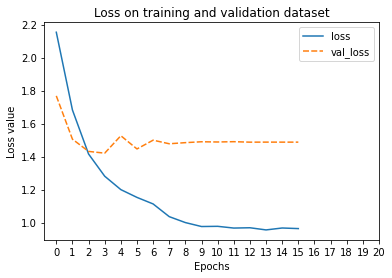

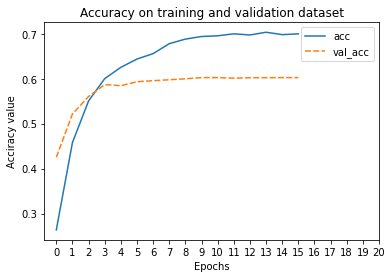

In [146]:
# Plot the training accuracy
history_dict = history.history

# Plot the loss results
df = pd.DataFrame(history_dict)
ax = sns.lineplot(data=df.iloc[:, :3:2])
ax.set_title('Loss on training and validation dataset')
ax.set_ylabel('Loss value')
ax.set_xlabel('Epochs')
sns.axes_style("whitegrid")
ax.set(xticks=np.arange(0,21,1));
plt.show()

# Plot the accuracy results
ax = sns.lineplot(data=df.iloc[:, 1::2])
ax.set_title('Accuracy on training and validation dataset')
ax.set_ylabel('Acciracy value')
ax.set_xlabel('Epochs')
sns.axes_style("whitegrid")
ax.set(xticks=np.arange(0,21,1));
plt.show()